# (1) Load albums data

In [1]:
import os, re, nltk
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize 

df_temp = pd.read_csv("Album_AgeGroup.csv")

In [2]:
df_temp.head()

,Age,Title,Artist,Year,Description,Age Group
0,2,Sesame Street: Halloween Collection,Sesame Street,2012,"Playful, not-so-spooky Halloween songs for th...",Toodler
1,2,A Child's Celebration of Rock 'n' Roll,Various Artists,1996,Songs to get toddlers and teens energized.,Toodler
2,2,Wake up Jeff,The Wiggles,2000,Songs and scenes certain to keep kids attenti...,Toodler
3,2,Toot Toot!,The Wiggles,2001,Gets little couch potatoes up and moving.,Toodler
4,2,A Child's Celebration of Classical Music,Various Artists,1999,Talented celebs promote classics for kids.,Toodler


# (2) For each album, use Genius API to find the lyrics. Save to a dataframe.

In [3]:
df_temp['Singles'] = df_temp['Title'].str.contains('CD Single', case = False, regex=False)


import re
singles = re.compile(re.escape('(CD Single)'), re.IGNORECASE)
# x = "Wash Your Hands (CD single)"    % Test regular expression replace
# singles.sub('', x)

df_temp.loc[df_temp['Singles'] == True,'Title'] = df_temp[df_temp['Singles'] == True]['Title'].apply(lambda x: singles.sub('',x).strip("\" "))


import lyricsgenius
df_temp['AlbumLyricsFileName'] = df_temp.apply(lambda x:"./lyrics/" + lyricsgenius.utils.sanitize_filename(x['Artist'] + "_" + x['Title']) +".json", axis = 1)
df_temp['AlbumLyricsFound'] =  df_temp['AlbumLyricsFileName'].apply(os.path.isfile)
df_temp = df_temp[df_temp['AlbumLyricsFound'] == True]  #Skip albums not found in Genius API



In [4]:
df_temp.head()

,Age,Title,Artist,Year,Description,Age Group,Singles,AlbumLyricsFileName,AlbumLyricsFound
0,2,Sesame Street: Halloween Collection,Sesame Street,2012,"Playful, not-so-spooky Halloween songs for th...",Toodler,False,./lyrics/Sesame Street_Sesame Street Halloween...,True
2,2,Wake up Jeff,The Wiggles,2000,Songs and scenes certain to keep kids attenti...,Toodler,False,./lyrics/The Wiggles_Wake up Jeff.json,True
3,2,Toot Toot!,The Wiggles,2001,Gets little couch potatoes up and moving.,Toodler,False,./lyrics/The Wiggles_Toot Toot.json,True
7,2,The Best of Elmo,Sesame Street,1997,Sesame Street fans love Elmo's fun-filled son...,Toodler,False,./lyrics/Sesame Street_The Best of Elmo.json,True
8,2,Fiesta Songs!,Sesame Street,1998,Parents may enjoy the music as much as their ...,Toodler,False,./lyrics/Sesame Street_Fiesta Songs.json,True


In [5]:

import json
df = pd.DataFrame(columns=['Album Title','Artist', 'Song Title', 'Lyrics', 'Age Group'])
for index, row in df_temp.iterrows():
    filename = row['AlbumLyricsFileName']
    album_title = row['Title']
    artist = row['Artist']
    age_group = row['Age Group']
    jsonfile = json.load(open(filename))
    if 'tracks' not in jsonfile:
        break
    for track in jsonfile['tracks']:
        if 'song' in track:
            song = track['song']
            if 'lyrics' in song and len(song['lyrics'])>0:
                lyrics = song['lyrics']
                title = song['title']
                df2 = {'Album Title': album_title, 'Artist': artist, 'Song Title': title, 'Lyrics': lyrics, 'Age Group': age_group}
                df = df.append(df2, ignore_index = True)

df.head()

,Album Title,Artist,Song Title,Lyrics,Age Group
0,Sesame Street: Halloween Collection,Sesame Street,Sammy The Snake,"(spoken)\nSssss! Say hey! I'm Sammy the snake,...",Toodler
1,Wake up Jeff,The Wiggles,We Like to Say Hello,The Big Red Car rolls along the street\nAnd to...,Toodler
2,Wake up Jeff,The Wiggles,Having Fun At The Beach,Greg: (singing) Having fun at the beach\nMurra...,Toodler
3,Wake up Jeff,The Wiggles,Wake Up Jeff,"Wake up, Jeff\nEverybody's wiggling\nWake up, ...",Toodler
4,Wake up Jeff,The Wiggles,Dorothy (Would You Like to Dance),"Spoken:\nCome on everybody, let's dance\nDorot...",Toodler


In [6]:
custom_dict = {'Toodler': 0, 'Pre-Schooler': 2, 'Middle Childhood 1': 3,'Middle Childhood 2': 4,
               "Young Teen": 5, "Teenager": 6, "Adult": 7 } 

df.groupby(by = 'Age Group').size().sort_index(key = lambda x: x.map(custom_dict)) 

Age Group
Toodler                712
Pre-Schooler           336
Middle Childhood 1     993
Middle Childhood 2    2747
Young Teen            6655
Teenager              2003
Adult                 1255
dtype: int64

# (3) Pre-processing Song Lyrics

In [18]:
import nltk
nltk.download('wordnet', quiet = True)
nltk.download('stopwords', quiet = True)

def preprocess(data):
    data_processed=[]
    for e in data['Lyrics']:       
        e = re.sub("[^a-zA-Z]", " ", e) # find alphabets
        e = e.lower()                   # convert to lower case
        e = nltk.word_tokenize(e)       # tokenize words
        e = [word for word in e if not word in set(stopwords.words("english"))]        # remove stopwords
        
        # lemmatization
        lemma = nltk.WordNetLemmatizer()
        e = [lemma.lemmatize(word) for word in e]
        n_tokens = len(e)
        n_unique_tokens = len(set(e))
        avgWordLength = sum([len(word) for word in e])/n_tokens
        e=" ".join(e)
        
        
        data_processed.append([e, n_tokens, n_unique_tokens, avgWordLength])
    return data_processed

df[["Lyrics_preprocessed", "Tokens", "Unique Tokens", "Avg Word Length"]] = preprocess(df)
df.to_csv("lyrics_preprocessed.csv", index = False)

path = os.path.join("lyrics_preprocessed.csv")
df = pd.read_csv(path)
df.fillna('', inplace=True)

df.head(3)

,Album Title,Artist,Song Title,Lyrics,Age Group,Lyrics_preprocessed,Tokens,Unique Tokens,Lexical Diversity,Avg Word Length
0,Sesame Street: Halloween Collection,Sesame Street,Sammy The Snake,"(spoken)\nSssss! Say hey! I'm Sammy the snake,...",Toodler,spoken sss say hey sammy snake tell people som...,115,49,0.327869,4.643478
1,Wake up Jeff,The Wiggles,We Like to Say Hello,The Big Red Car rolls along the street\nAnd to...,Toodler,big red car roll along street people meet like...,129,33,0.261780,4.007752
2,Wake up Jeff,The Wiggles,Having Fun At The Beach,Greg: (singing) Having fun at the beach\nMurra...,Toodler,greg singing fun beach murray anthony jeff fun...,224,42,0.143204,4.776786


In [19]:
df['Lexical Diversity'] = df['Unique Tokens']/df['Tokens']

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14559 entries, 0 to 14618
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Album Title          14559 non-null  object 
 1   Artist               14559 non-null  object 
 2   Song Title           14559 non-null  object 
 3   Lyrics               14559 non-null  object 
 4   Age Group            14559 non-null  object 
 5   Lyrics_preprocessed  14559 non-null  object 
 6   Tokens               14559 non-null  int64  
 7   Unique Tokens        14559 non-null  int64  
 8   Lexical Diversity    14559 non-null  float64
 9   Avg Word Length      14559 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 1.7+ MB


In [20]:
df.groupby(by = 'Age Group')['Avg Word Length'].mean()

Age Group
Adult                 4.601094
Middle Childhood 1    4.642521
Middle Childhood 2    4.710154
Pre-Schooler          4.831722
Teenager              4.647890
Toodler               4.666117
Young Teen            4.711719
Name: Avg Word Length, dtype: float64

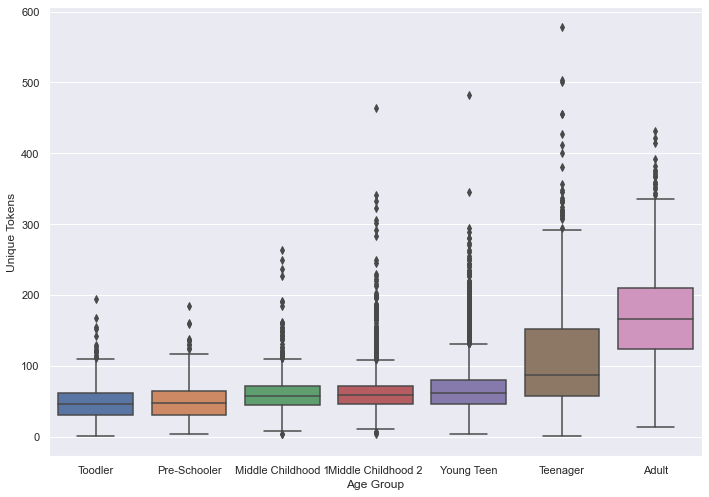

In [24]:
def age_group(age):
    if age < 4: return "Toodler"
    elif age < 6: return "Pre-Schooler"
    elif age < 9: return "Middle Childhood 1"
    elif age < 12: return "Middle Childhood 2"
    elif age < 15: return "Young Teen"
    elif age < 18: return "Teenager"
    else: return "Adult"

custom_dict = {'Toodler': 0, 'Pre-Schooler': 2, 'Middle Childhood 1': 3,'Middle Childhood 2': 4,
               "Young Teen": 5, "Teenager": 6, "Adult": 7 } 

df = df[(df['Tokens'] >= 20) & (df['Tokens'] < 2000)]
df = df.sort_index(key = lambda x: x.map(custom_dict))    


sns.set(rc={'figure.figsize':(11.7,8.27)})

#ax = sns.boxplot(x="Age Group", y="Lexical Diversity", data=df)
ax = sns.boxplot(x="Age Group", y="Unique Tokens", data=df)
#ax = sns.boxplot(x="Age Group", y="Avg Word Length", data=df)


In [11]:
df

,Album Title,Artist,Song Title,Lyrics,Age Group,Lyrics_preprocessed,Tokens,Unique Tokens,Lexical Diversity
0,Sesame Street: Halloween Collection,Sesame Street,Sammy The Snake,"(spoken)\nSssss! Say hey! I'm Sammy the snake,...",Toodler,spoken sss say hey i m sammy the snake and i m...,244,80,0.327869
1,Wake up Jeff,The Wiggles,We Like to Say Hello,The Big Red Car rolls along the street\nAnd to...,Toodler,the big red car roll along the street and to a...,191,50,0.261780
2,Wake up Jeff,The Wiggles,Having Fun At The Beach,Greg: (singing) Having fun at the beach\nMurra...,Toodler,greg singing having fun at the beach murray an...,412,59,0.143204
3,Wake up Jeff,The Wiggles,Wake Up Jeff,"Wake up, Jeff\nEverybody's wiggling\nWake up, ...",Toodler,wake up jeff everybody s wiggling wake up jeff...,173,71,0.410405
4,Wake up Jeff,The Wiggles,Dorothy (Would You Like to Dance),"Spoken:\nCome on everybody, let's dance\nDorot...",Toodler,spoken come on everybody let s dance dorothy d...,141,45,0.319149
...,...,...,...,...,...,...,...,...,...
14696,Trigga,Trey Songz,Late Night,"Trigga\nYour boy Juicy J, yeah\nY'all know wha...",Adult,trigga your boy juicy j yeah y all know what i...,921,185,0.200869
14697,Trigga,Trey Songz,SmartPhones,She picks up the phone\nIn my head I know I'm ...,Adult,she pick up the phone in my head i know i m wr...,411,100,0.243309
14698,Trigga,Trey Songz,"Yes, No, Maybe","Yes, no, maybe\nYes, no, maybe\n\nRemember whe...",Adult,yes no maybe yes no maybe remember when you us...,750,183,0.244000
14699,Trigga,Trey Songz,Y.A.S. (You Ain’t Shit),She giving me the side eye\nSaying she ain't s...,Adult,she giving me the side eye saying she ain t st...,810,218,0.269136
